In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
from statsmodels.tsa.stattools import coint
from itertools import combinations
from sklearn.preprocessing import MinMaxScaler

plt.style.use('fivethirtyeight')

In [2]:
crypto_forex_stocks = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'XRP-USD', 'ADA-USD', 'DOGE-USD', 'ETC-USD', 'XLM-USD', 'AAVE-USD', 
                       'EOS-USD', 'XTZ-USD', 'ALGO-USD', 'XMR-USD', 'KCS-USD', 'MKR-USD', 'BSV-USD', 'RUNE-USD', 'DASH-USD', 
                       'KAVA-USD', 'ICX-USD', 'LINA-USD', 'WAXP-USD', 'LSK-USD', 'EWT-USD', 'XCN-USD', 'HIVE-USD', 'FTX-USD', 
                       'RVN-USD', 'SXP-USD', 'BTCB-USD']
bank_stocks = ['JPM', 'BAC', 'WFC', 'C', 'GS', 'MS', 'DB', 'UBS', 'BBVA', 'SAN', 'ING', ' BNPQY', 'HSBC', 'SMFG', 'PNC', 'USB', 
               'BK', 'STT', 'KEY', 'RF', 'HBAN', 'FITB',  'CFG', 'BLK', 'ALLY', 'MTB', 'NBHC', 'ZION', 'FFIN', 'FHN', 'UBSI', 
               'WAL', 'PACW', 'SBCF', 'TCBI', 'BOKF', 'PFG', 'GBCI', 'TFC', 'CFR', 'UMBF', 'SPFI', 'FULT', 'ONB', 'INDB', 'IBOC',
                'HOMB']
global_indexes = ['^DJI', '^IXIC', '^GSPC', '^FTSE', '^N225', '^HSI', '^AXJO', '^KS11', '^BFX', '^N100',
                  '^RUT', '^VIX', '^TNX']

start = '2021-01-01'
end = '2023-12-31'
tickers = crypto_forex_stocks + bank_stocks + global_indexes
tickers_map = {ticker: yf.Ticker(ticker).history(start=start, end=end) for ticker in tickers}

 BNPQY: No timezone found, symbol may be delisted


In [3]:
def clean_data(data_map):
    for data in data_map.values():
        data.index = pd.to_datetime(data.index).tz_localize(None)
        
    df = pd.concat([data['Close'] for data in data_map.values()], axis=1, keys=data_map.keys())

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.interpolate(method='linear', inplace=True)
    df.fillna(method='pad', inplace=True)
    df.fillna(method='bfill', inplace=True)
    df.dropna(axis=1, how='all', inplace=True)

    return df    

In [4]:
cleaned_data = clean_data(tickers_map)
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1094 entries, 2021-01-01 to 2023-12-30
Freq: D
Data columns (total 89 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   BTC-USD   1094 non-null   float64
 1   ETH-USD   1094 non-null   float64
 2   BNB-USD   1094 non-null   float64
 3   XRP-USD   1094 non-null   float64
 4   ADA-USD   1094 non-null   float64
 5   DOGE-USD  1094 non-null   float64
 6   ETC-USD   1094 non-null   float64
 7   XLM-USD   1094 non-null   float64
 8   AAVE-USD  1094 non-null   float64
 9   EOS-USD   1094 non-null   float64
 10  XTZ-USD   1094 non-null   float64
 11  ALGO-USD  1094 non-null   float64
 12  XMR-USD   1094 non-null   float64
 13  KCS-USD   1094 non-null   float64
 14  MKR-USD   1094 non-null   float64
 15  BSV-USD   1094 non-null   float64
 16  RUNE-USD  1094 non-null   float64
 17  DASH-USD  1094 non-null   float64
 18  KAVA-USD  1094 non-null   float64
 19  ICX-USD   1094 non-null   float64
 20  LINA

In [5]:
def coint_matrix(df):
    tickers = df.columns
    p_values = np.ones((len(tickers), len(tickers)))
    close_matrix = np.column_stack([df[ticker] for ticker in tickers])
    for i, j in combinations(range(len(tickers)), 2):
        result = coint(close_matrix[:, i], close_matrix[:, j])
        if result[1] < 0.05:
            p_values[i, j] = result[1]

    pairs = [(tickers[i], tickers[j], p_values[i, j]) for i, j in zip(*np.where(p_values < 0.05))]

    return p_values, pairs

In [6]:
p_values, pairs = coint_matrix(cleaned_data)

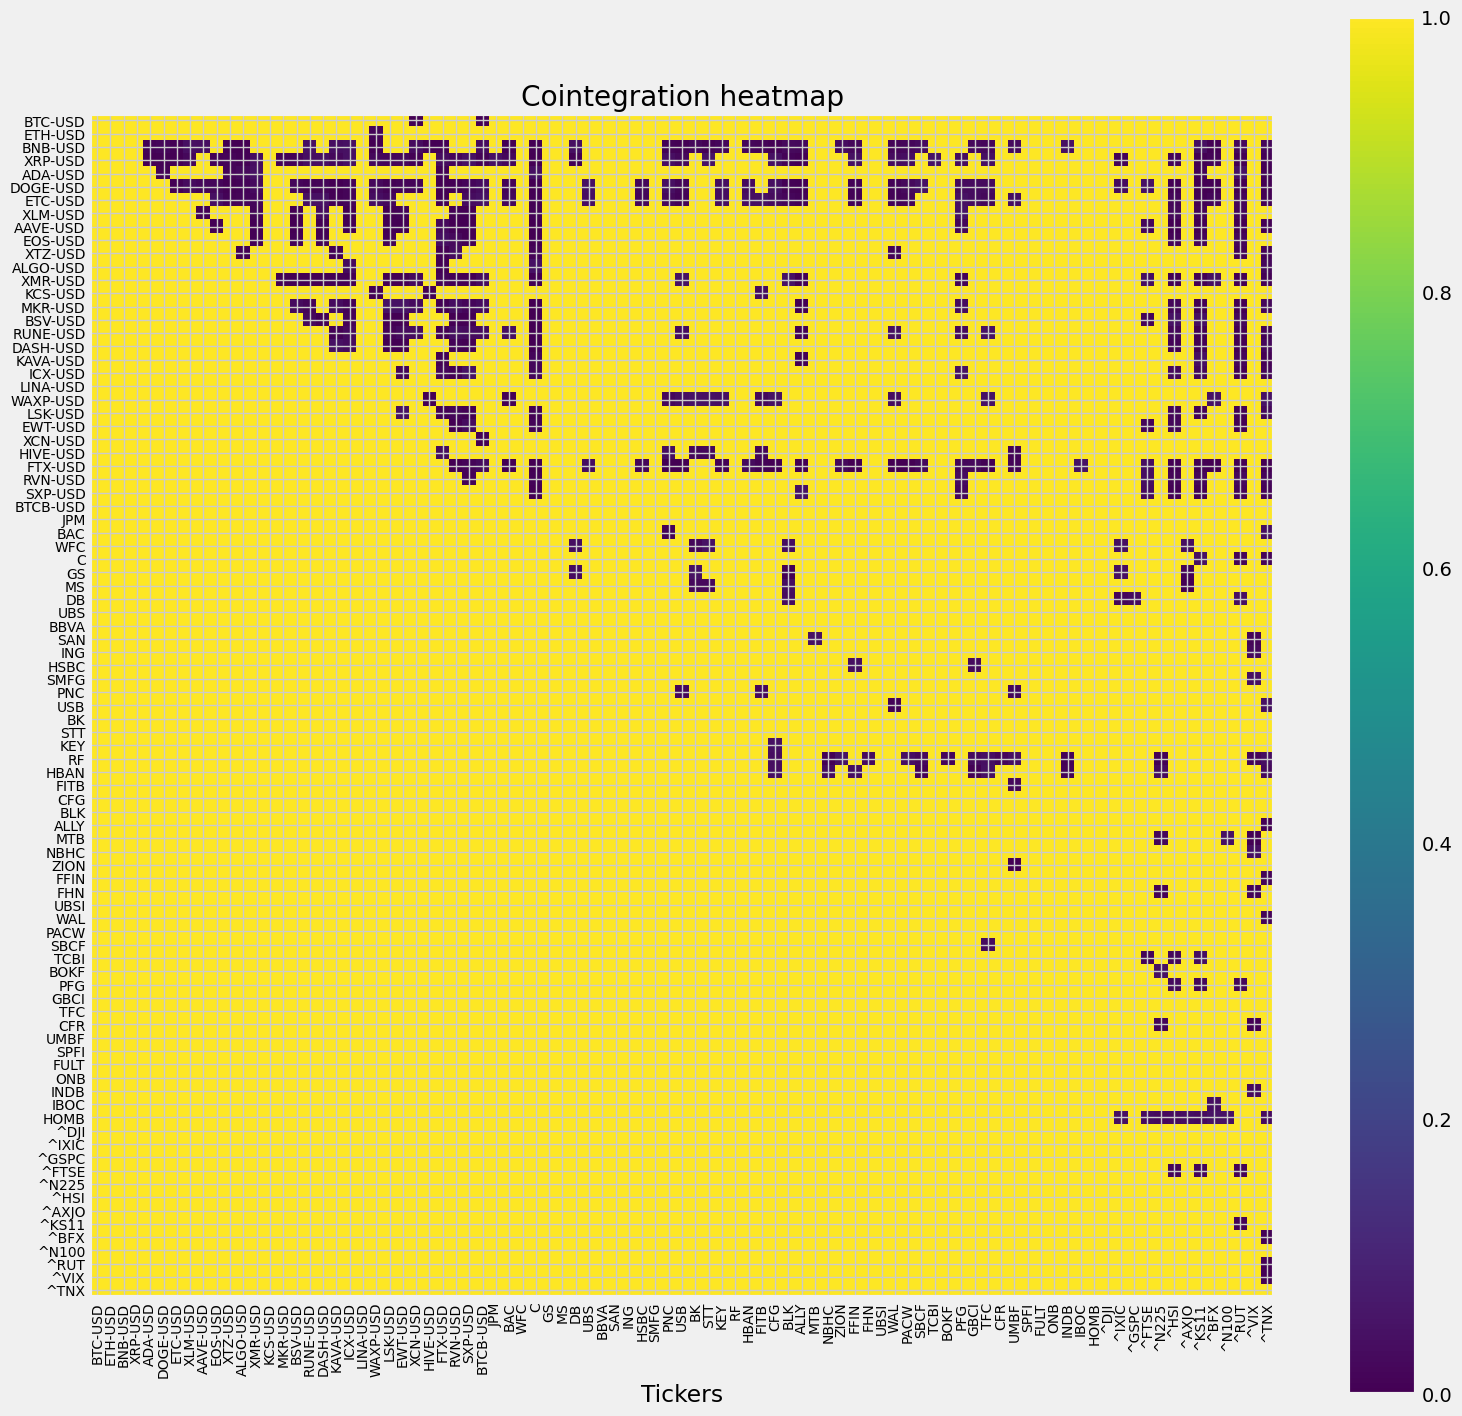

In [7]:
fig, ax = plt.subplots(figsize=(17,17))
heatmap = ax.imshow(p_values, cmap='viridis')
colorbar = plt.colorbar(heatmap)
ax.set_xticks(np.arange(len(cleaned_data.columns)), labels=cleaned_data.columns, fontsize=10)
ax.set_yticks(np.arange(len(cleaned_data.columns)), labels=cleaned_data.columns, fontsize=10)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.title('Cointegration heatmap')
plt.xlabel('Tickers')
plt.show()

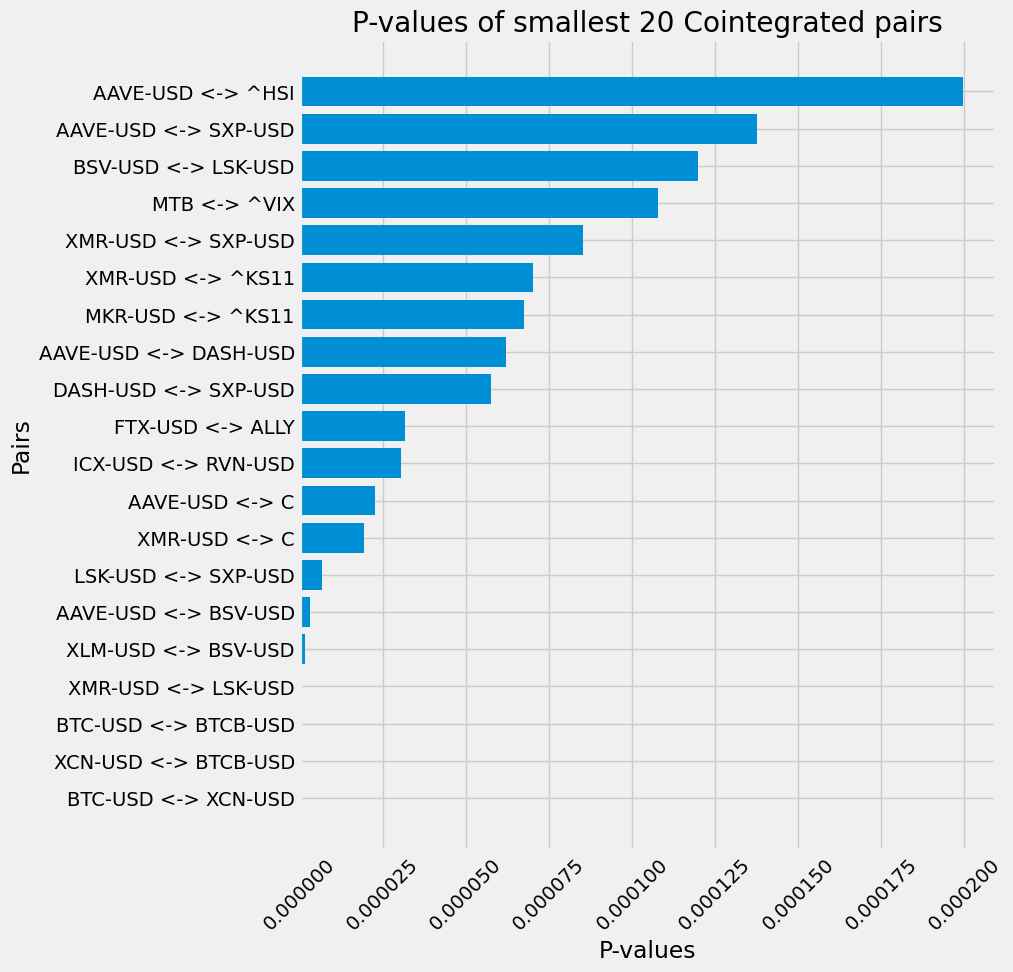

In [8]:
sorted_pairs = sorted(pairs, key=lambda x: x[2], reverse=False)
sub_sorted_pairs = sorted_pairs[0:20]
sub_sorted_pairs
pair_labels, p_vals = zip(*[(f'{y1} <-> {y2}', p) for y1, y2, p in sub_sorted_pairs])
plt.figure(figsize=(8,10))
plt.barh(pair_labels, p_vals)
plt.xticks(rotation=45)
plt.title('P-values of smallest 20 Cointegrated pairs')
plt.xlabel('P-values')
plt.ylabel('Pairs')
plt.show()

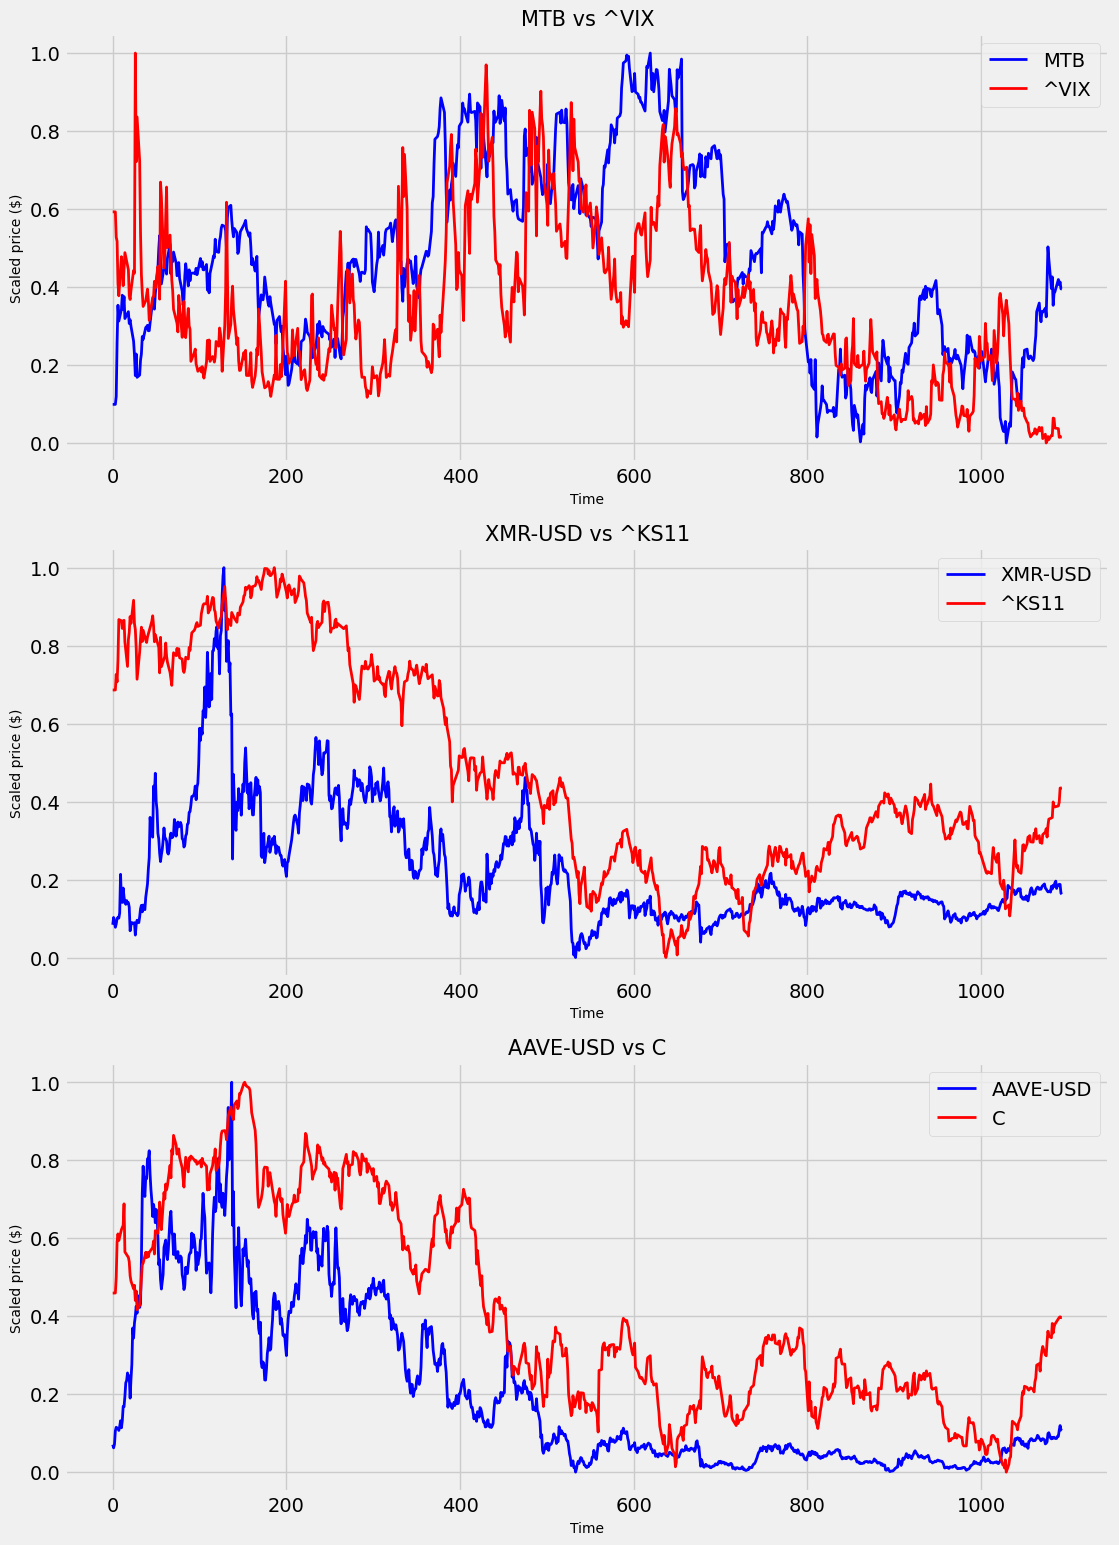

In [14]:
ticker_pairs = [('MTB', '^VIX'), ('XMR-USD', '^KS11'), ('AAVE-USD', 'C')]
fig, ax = plt.subplots(3, 1, figsize=(12,18))
scaler = MinMaxScaler()
for i, (t1, t2) in enumerate(ticker_pairs):
    scaled_data_1 = scaler.fit_transform(cleaned_data[t1].values.reshape(-1, 1))
    scaled_data_2 = scaler.fit_transform(cleaned_data[t2].values.reshape(-1, 1))
    ax[i].plot(scaled_data_1, label=t1, color='blue', linewidth=2.0)
    ax[i].plot(scaled_data_2, label=t2, color='red', linewidth=2.0)
    ax[i].set_title(f'{t1} vs {t2}', fontsize=15)
    ax[i].set_ylabel('Scaled price ($)', fontsize=10)
    ax[i].set_xlabel('Time', fontsize=10)
    ax[i].legend()

plt.show()

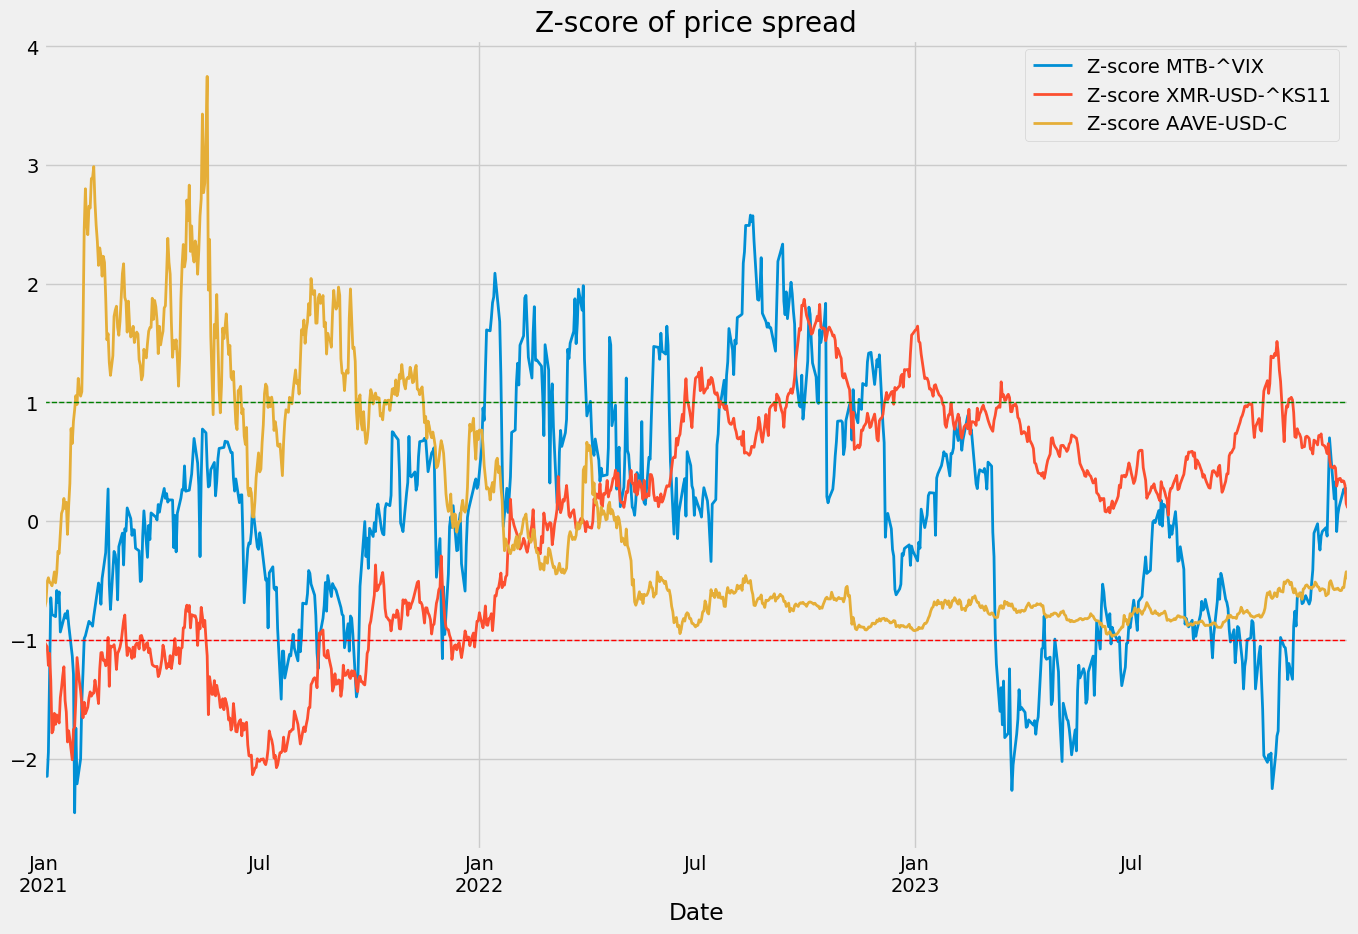

In [24]:
spread = pd.DataFrame()
for t1, t2 in ticker_pairs:
    spread[f'{t1}-{t2}'] = cleaned_data[t1] - cleaned_data[t2]
    spread[f'Z-score {t1}-{t2}'] = (spread[f'{t1}-{t2}'] - spread[f'{t1}-{t2}'].mean())/spread[f'{t1}-{t2}'].std()
    spread[f'Z-score {t1}-{t2}'].plot(linewidth=2.0, figsize=(15,10))

plt.axhline(1.0, color='g', linestyle='--', linewidth=1.0)
plt.axhline(-1.0, color='r', linestyle='--', linewidth=1.0)
plt.title('Z-score of price spread')
plt.legend()
plt.show()

In [ ]:
def strategy(df):
    pass